# Total Competition
Stacked bar plots of Formula 1 constructors' points from https://ergast.com/mrd/db

In [1]:
%autosave 0
%load_ext autoreload
%autoreload 2

from tools import F1_ZIPPED
from etl.ergast import ErgastF1
from viz.plot import Plot

f1 = ErgastF1(F1_ZIPPED)
plot = Plot()

Autosave disabled


## Which teams scored the most points?
Get points for each (race, team) for all available races.

In [2]:
points = (
    f1.team_results
    .loc[lambda df: df['points'].gt(0)]
    .join(f1.races['season round race'.split()], on='id_race')
    .join(f1.teams['team'], on='id_team')
    ['season race round points team'.split()]
    .sort_values('season round points'.split())
    .reset_index(drop=True)
)
points

,season,race,round,points,team
0,1956,Argentine Grand Prix,1,12.0,Ferrari
1,1956,Argentine Grand Prix,1,13.0,Maserati
2,1956,German Grand Prix,7,9.0,Ferrari
3,1956,German Grand Prix,7,15.0,Maserati
4,1958,Argentine Grand Prix,1,3.0,Maserati
...,...,...,...,...,...
4933,2019,Abu Dhabi Grand Prix,21,5.0,McLaren
4934,2019,Abu Dhabi Grand Prix,21,6.0,Racing Point
4935,2019,Abu Dhabi Grand Prix,21,25.0,Ferrari
4936,2019,Abu Dhabi Grand Prix,21,26.0,Red Bull


## the colors of money
A few well-funded teams usually score most of the points each year.

In [3]:
from collections import defaultdict

color = {
    'BAR': '#77bb77',
    'Benetton': '#00bb00',
    'BMW Sauber': '#bbbbbb',
    'Brawn': '#bbff00',
    'Ferrari': "#ff0000",
    'McLaren': "#ffbb00",
    'Mercedes': '#00ffff',
    'Red Bull': '#330077',
    'Renault': '#00bbff',
    'Williams': '#0000ff',
    'Jordan': '#ffff00'
}
color = defaultdict(lambda: '#000000', color)

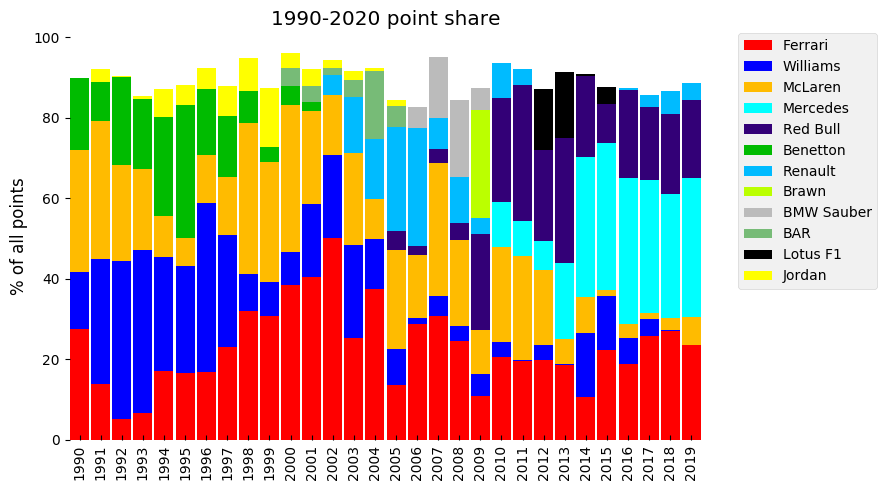

In [4]:
def yearshare(start, stop, n=12, **kwargs):
    data = (
        points.loc[points['season'].between(start, stop)]
        .groupby('season team'.split())
        ['points'].sum().unstack('team', fill_value=0)
    )
    data = 100 * data.div(data.sum(axis=1), axis=0)
    data = data[data.max().nlargest(n).index]
    kwargs.setdefault('color', data.columns.map(color))
    kwargs.setdefault('title', f"{start}-{stop} point share")
    kwargs.setdefault('ylabel', '% of all points')    
    plot.bar(data, **kwargs)
    
yearshare(1990, 2020)

## a clockwork red
Ferrari won every constructors' title from 1999 through 2004.

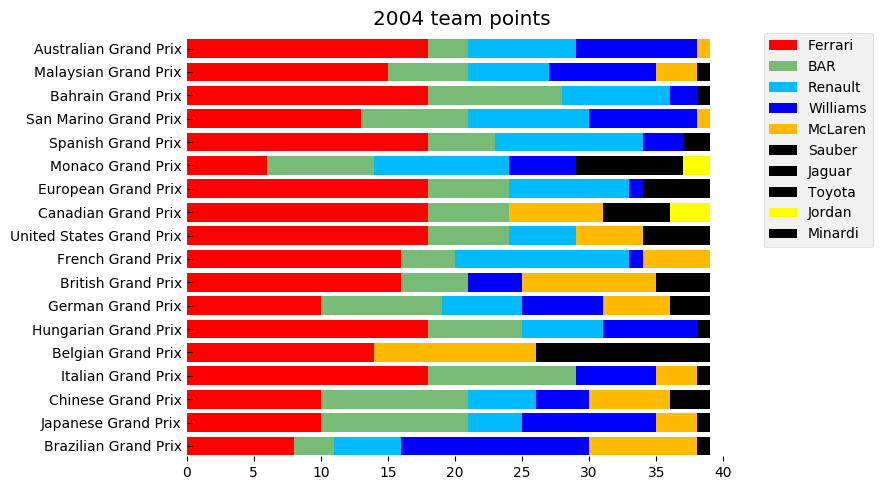

In [5]:
def racepoints(season, n=12, **kwargs):
    data = (
        points.loc[points['season'].eq(season)]
        .groupby('race team'.split(), sort=False)
        ['points'].sum().unstack('team', fill_value=0)
    )    
    data = data[data.sum().nlargest(n).index]
    kwargs.setdefault('color', data.columns.map(color))
    kwargs.setdefault('title', f"{season} team points")
    plot.barh(data, **kwargs)

racepoints(2004)